# Import Libraries

In [137]:
import os
import pandas as pd 
import numpy as np
import json
import random
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, Model,Input
from tensorflow.keras.models import Sequential ,load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten,Dense,Dropout, BatchNormalization, Input,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0,EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Prepare & split Dataset

In [2]:
dataset_path= '/kaggle/input/eye-diseases-classification/dataset'

corrupted_files=[]

for cls in os.listdir(dataset_path):
    cls_path=os.path.join(dataset_path,cls)
    if os.path.isdir(cls_path):
        files=[f for f in os.listdir(cls_path)
        if not f.startswith('.') and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        valid_count=0


    for f in files:
        file_path=os.path.join(cls_path,f)
        try:
            img=Image.open(file_path)
            img.verify()
            valid_count+=1
            
        except Exception as e:
            print(f'Corrupted or unreadeable img {file_path} : {e}')
            corrupted_files.append(file_path)
            
    print(f"{cls}: {valid_count} valid images / {len(files)} total files")

print(f"\nTotal corrupted images: {len(corrupted_files)}")
            

glaucoma: 1007 valid images / 1007 total files
normal: 1074 valid images / 1074 total files
diabetic_retinopathy: 1098 valid images / 1098 total files
cataract: 1038 valid images / 1038 total files

Total corrupted images: 0


In [3]:
dataset_path = '/kaggle/input/eye-diseases-classification/dataset'

OUT_DIR = '/kaggle/working/dataset_split'

split_ratio={'train':0.7 , 'val': 0.15 , 'test': 0.15}

# Step 1: create folders
for split in split_ratio:
    for cls in os.listdir(dataset_path):
        os.makedirs(os.path.join(OUT_DIR,split,cls),exist_ok=True)

# Step 2: copy images into train/val/test
for cls in os.listdir(dataset_path):
    cls_path=os.path.join(dataset_path,cls)
    files=os.listdir(cls_path)
    random.shuffle(files)
    n=len(files)

    train_end=int(n*split_ratio['train'])
    val_end=train_end+int(n*split_ratio['val'])

    for i, file in enumerate(files):
        src=os.path.join(cls_path, file)

        if i< train_end:
            dst=os.path.join(OUT_DIR, 'train', cls, file)
        elif i< val_end:
            dst=os.path.join(OUT_DIR, 'val', cls, file)
        else:
            dst=os.path.join(OUT_DIR, 'test', cls, file)

        shutil.copyfile(src,dst)

In [4]:
for split in ['train','val','test']:
    print(f"\n{split} split:")
    for cls in os.listdir(os.path.join(OUT_DIR, split)):
        n = len(os.listdir(os.path.join(OUT_DIR, split, cls)))
        print(f"{cls}: {n} images")



train split:
normal: 977 images
diabetic_retinopathy: 996 images
cataract: 950 images
glaucoma: 923 images

val split:
normal: 293 images
diabetic_retinopathy: 298 images
cataract: 292 images
glaucoma: 282 images

test split:
normal: 304 images
diabetic_retinopathy: 302 images
cataract: 289 images
glaucoma: 283 images


# load dataset

In [5]:
IMG_SIZE = (224, 224) 
BATCH_SIZE = 32

train_ds=tf.keras.utils.image_dataset_from_directory(
    '/kaggle/working/dataset_split/train',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    # shuffle=True
)

CLASS_NAMES = train_ds.class_names

val_ds=tf.keras.utils.image_dataset_from_directory(
    '/kaggle/working/dataset_split/val',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds=tf.keras.utils.image_dataset_from_directory(
    '/kaggle/working/dataset_split/test',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 3846 files belonging to 4 classes.


I0000 00:00:1768412749.935544    3044 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 1165 files belonging to 4 classes.
Found 1178 files belonging to 4 classes.


In [6]:
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels)       


(32, 224, 224, 3)
tf.Tensor([1 0 2 0 0 1 3 1 1 3 3 1 2 0 2 1 2 0 0 2 1 1 0 3 2 2 2 2 0 0 3 0], shape=(32,), dtype=int32)


In [7]:
with open ('CLASS_NAMES.json','w') as f:
    json.dump(CLASS_NAMES,f)

# Show Sample Of Images

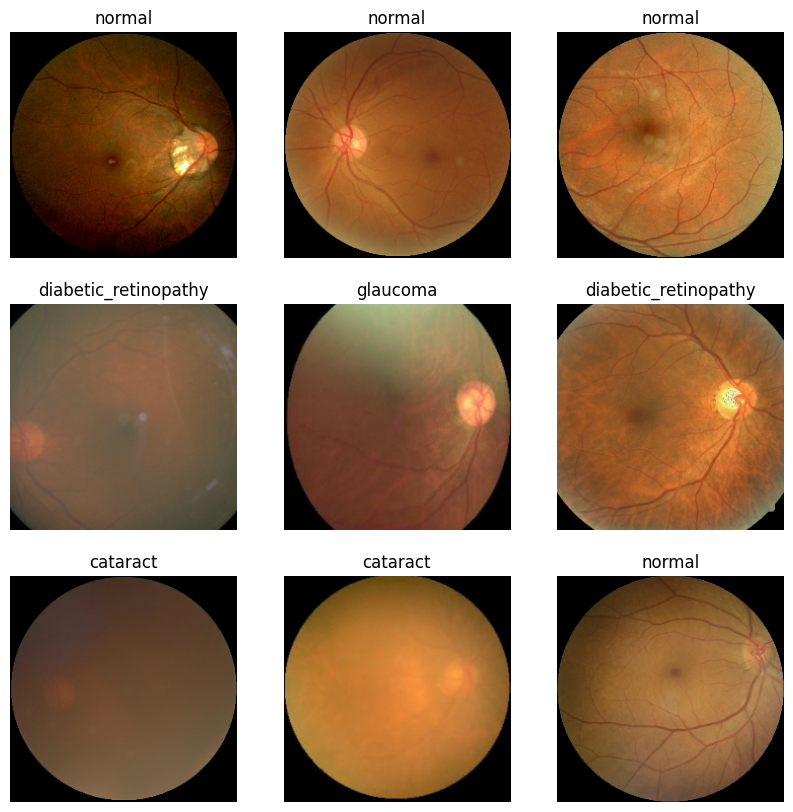

In [8]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis('off')
plt.show()

# Data Augmentation

In [9]:
data_aug=tf.keras.Sequential([
    layers.RandomFlip('horizontal'),    # flip left-right
    layers.RandomRotation(0.1),         # rotate ±10%
    layers.RandomZoom(0.1),             # zoom in/out
    layers.RandomContrast(0.1),         # adjust brightness
])

In [10]:
train_ds = train_ds.shuffle(1000)
train_ds_original = train_ds.map(lambda x, y: (x/255.0, y))    
train_ds_cnn=train_ds.map(lambda x,y:(data_aug(x, training=True)/255.0,y))

val_ds_cnn=val_ds.map(lambda x,y:(x/255.0,y))
test_ds_cnn=test_ds.map(lambda x,y:(x/255.0,y))

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_cnn = train_ds_cnn.prefetch(buffer_size=AUTOTUNE)
val_ds_cnn = val_ds_cnn.prefetch(buffer_size=AUTOTUNE)
test_ds_cnn = test_ds_cnn.prefetch(buffer_size=AUTOTUNE)

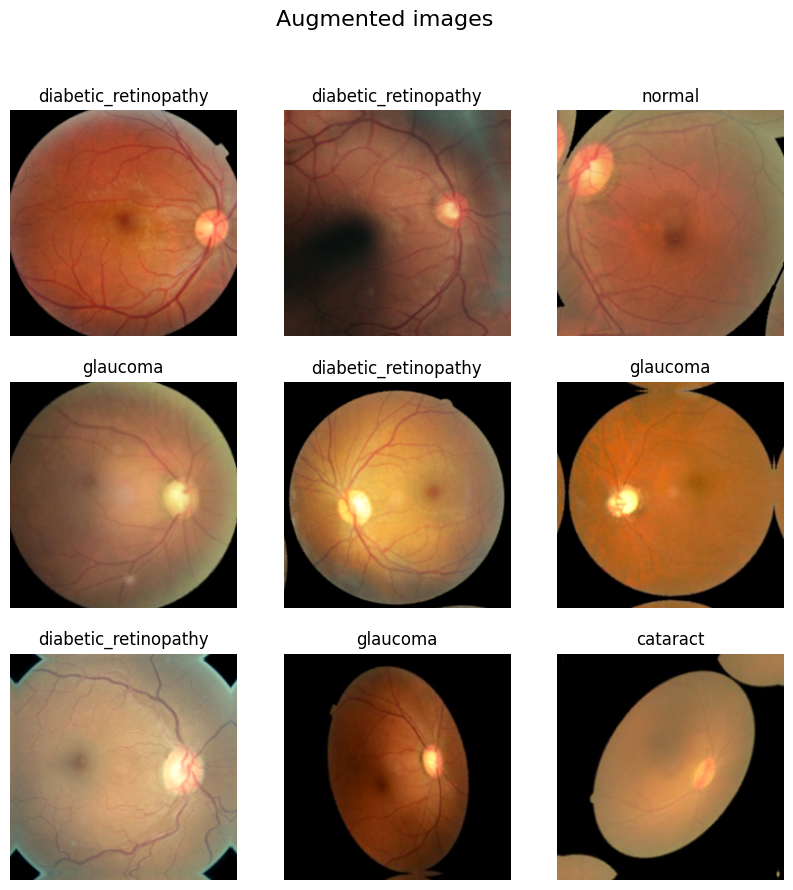

In [12]:
plt.figure(figsize=(10,10))
for images, labels in train_ds_cnn.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis('off')

plt.suptitle("Augmented images", fontsize=16)
plt.show()

In [13]:
original_images, original_labels= next(iter(train_ds_original.take(1)))
aug_images, aug_labels= next(iter(train_ds_cnn.take(1)))

# Show Sample Of Images befor & After Augmentation

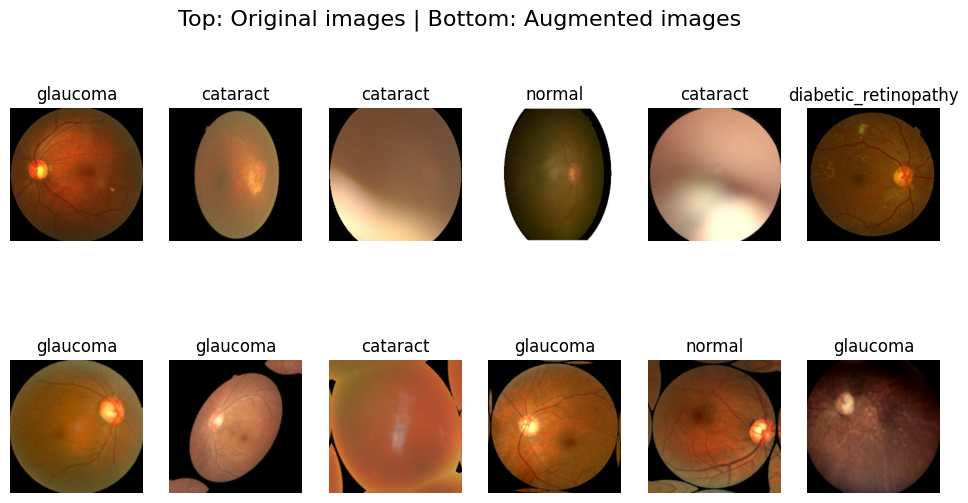

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i in range(6):
    # Original image
    ax = plt.subplot(2, 6, i + 1)
    plt.imshow((original_images[i].numpy() * 255).astype("uint8"))
    plt.title(CLASS_NAMES[original_labels[i]])
    plt.axis("off")
    
    # Augmented image
    ax = plt.subplot(2, 6, i + 7)
    plt.imshow((aug_images[i].numpy() * 255).astype("uint8"))
    plt.title(CLASS_NAMES[aug_labels[i]])
    plt.axis("off")

plt.suptitle("Top: Original images | Bottom: Augmented images", fontsize=16)
plt.show()


# CNN Model

In [15]:
#build the model
cnn_model = Sequential([


    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(244,244,3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

In [16]:
cnn_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 244, 244, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 244, 244, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 122, 122, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 122, 122, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 122, 122, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 715,812 (2.73 MB)

 Trainable params: 715,812 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
#callback
early_stopping= EarlyStopping(
    patience=10, 
    restore_best_weights=True
) 


reduce_lr =ReduceLROnPlateau(
    monitor='val_acc',
    patience=2,
    verbose=1,
    factor=0.5,
    min_lr=1e-6
)

# Train CNN Model

In [19]:
history=cnn_model.fit(
    train_ds_cnn,
    epochs=100,
    validation_data=val_ds_cnn,
    callbacks=[early_stopping,reduce_lr]
)

Epoch 1/100


I0000 00:00:1768412786.683256    3108 service.cc:152] XLA service 0x796ba0005cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768412786.683297    3108 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768412787.142979    3108 cuda_dnn.cc:529] Loaded cuDNN version 91002


  2/121 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.3047 - loss: 1.3840  

I0000 00:00:1768412795.590030    3108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


121/121 ━━━━━━━━━━━━━━━━━━━━ 68s 416ms/step - accuracy: 0.2878 - loss: 1.3755 - val_accuracy: 0.4618 - val_loss: 1.1607 - learning_rate: 0.0010
Epoch 2/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 51s 364ms/step - accuracy: 0.4367 - loss: 1.1746 - val_accuracy: 0.4180 - val_loss: 1.1525 - learning_rate: 0.0010
Epoch 3/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.4698 - loss: 1.1146 - val_accuracy: 0.4953 - val_loss: 1.1028 - learning_rate: 0.0010
Epoch 4/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.5068 - loss: 1.0542 - val_accuracy: 0.5648 - val_loss: 0.9999 - learning_rate: 0.0010
Epoch 5/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 51s 366ms/step - accuracy: 0.5974 - loss: 0.9153 - val_accuracy: 0.5957 - val_loss: 0.8915 - learning_rate: 0.0010
Epoch 6/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 51s 364ms/step - accuracy: 0.6088 - loss: 0.8641 - val_accuracy: 0.6807 - val_loss: 0.7650 - learning_rate: 0.0010
Epoch 7/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.6616 -

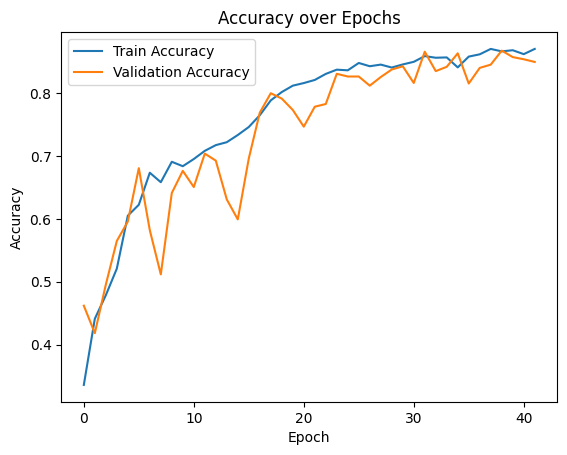

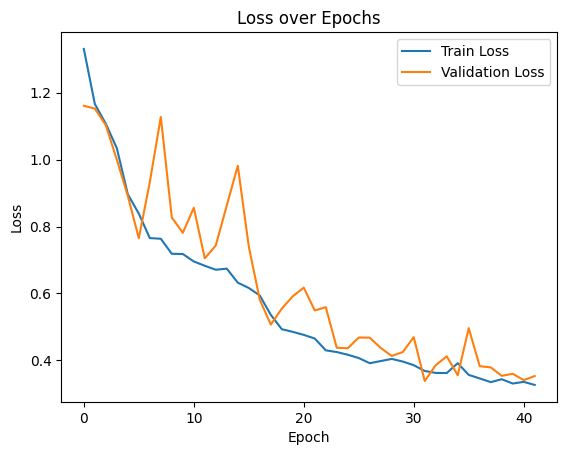

In [20]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Evaluate CNN Model

In [21]:
test_loss, test_acc= cnn_model.evaluate(test_ds_cnn)
print(f"test_loss: , {test_loss}  , test_acc: {test_acc} ")

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.8844 - loss: 0.2815
test_loss: , 0.3125734329223633  , test_acc: 0.8794566988945007 


In [22]:
y_true=np.concatenate([y for x, y in test_ds_cnn],axis=0)
y_pred=np.concatenate([np.argmax(cnn_model.predict(x),axis=1)for x, y in test_ds_cnn], axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━

In [23]:
report=classification_report(y_true, y_pred, target_names=CLASS_NAMES)
print(report)

                      precision    recall  f1-score   support

            cataract       0.91      0.90      0.90       289
diabetic_retinopathy       0.97      0.99      0.98       302
            glaucoma       0.91      0.68      0.78       283
              normal       0.76      0.93      0.84       304

            accuracy                           0.88      1178
           macro avg       0.89      0.88      0.88      1178
        weighted avg       0.89      0.88      0.88      1178



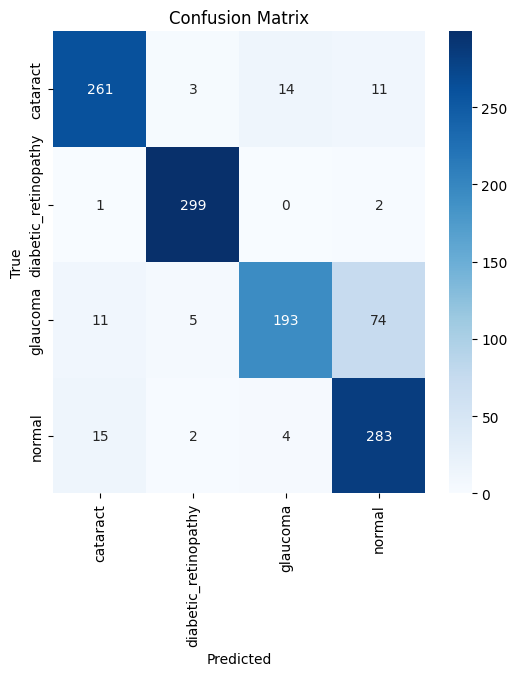

In [25]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES,
            cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [26]:
cnn_model.save("eye_cnn_model.h5")

# Test CNN Model By Image

In [27]:
img_path = "/kaggle/input/eye-test/eye.jpg"
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)/255.0
img_array = tf.expand_dims(img_array, axis=0)  # batch dimension

pred = cnn_model.predict(img_array)
print(f"Predicted class: {CLASS_NAMES[np.argmax(pred)]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
Predicted class: normal


# EfficientNetB0

In [110]:
inputs = Input(shape=(224,224,3))   
x = data_aug(inputs)                 
x = preprocess_input(x)               

base = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)        
)

base.trainable = False

x = base(x)                           
x = GlobalAveragePooling2D()(x)
outputs = Dense(4, activation="softmax")(x)

model = Model(inputs, outputs)

In [111]:
efficient_b0_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [112]:
efficient_b0_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ sequential[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [113]:
#callback
early_stopping= EarlyStopping(
    patience=10, 
    restore_best_weights=True
) 


reduce_lr =ReduceLROnPlateau(
    monitor='val_acc',
    patience=2,
    verbose=1,
    factor=0.5,
    min_lr=1e-6
)

In [114]:
history_b0=efficient_b0_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping,reduce_lr]

)

Epoch 1/100


E0000 00:00:1768425424.727503    3044 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


121/121 ━━━━━━━━━━━━━━━━━━━━ 29s 92ms/step - accuracy: 0.9327 - loss: 0.1858 - val_accuracy: 0.8850 - val_loss: 0.3542 - learning_rate: 0.0010
Epoch 2/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.9299 - loss: 0.1842 - val_accuracy: 0.8807 - val_loss: 0.3782 - learning_rate: 0.0010
Epoch 3/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.9368 - loss: 0.1778 - val_accuracy: 0.8850 - val_loss: 0.3452 - learning_rate: 0.0010
Epoch 4/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.9324 - loss: 0.1700 - val_accuracy: 0.8481 - val_loss: 0.4544 - learning_rate: 0.0010
Epoch 5/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.9244 - loss: 0.1908 - val_accuracy: 0.8841 - val_loss: 0.3770 - learning_rate: 0.0010
Epoch 6/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.9378 - loss: 0.1722 - val_accuracy: 0.8944 - val_loss: 0.3260 - learning_rate: 0.0010
Epoch 7/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.9203 - loss: 

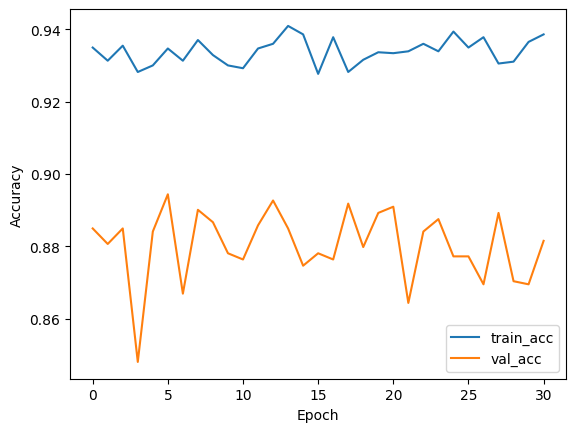

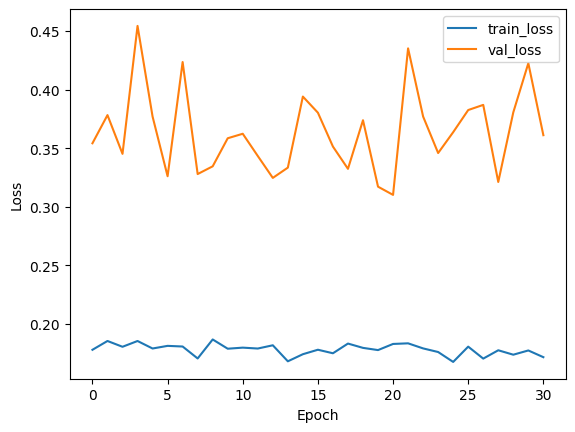

In [115]:
plt.plot(history_b0.history['accuracy'], label='train_acc')
plt.plot(history_b0.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history_b0.history['loss'], label='train_loss')
plt.plot(history_b0.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [116]:
test_loss, test_acc= efficient_b0_model.evaluate(test_ds)
print(f"tess_loss: {test_loss}")
print(f"test_acc: {test_acc}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.8848 - loss: 0.3275
tess_loss: 0.3117363750934601
test_acc: 0.8930390477180481


In [117]:
y_true=np.concatenate([y for x, y in test_ds],axis=0)
y_pred=np.concatenate([np.argmax(efficient_b0_model.predict(x),axis=1)for x, y in test_ds], axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━

In [118]:
report=classification_report(y_true, y_pred, target_names=CLASS_NAMES)
print(report)

                      precision    recall  f1-score   support

            cataract       0.97      0.88      0.92       289
diabetic_retinopathy       0.90      0.98      0.94       302
            glaucoma       0.92      0.74      0.82       283
              normal       0.82      0.96      0.89       304

            accuracy                           0.89      1178
           macro avg       0.90      0.89      0.89      1178
        weighted avg       0.90      0.89      0.89      1178



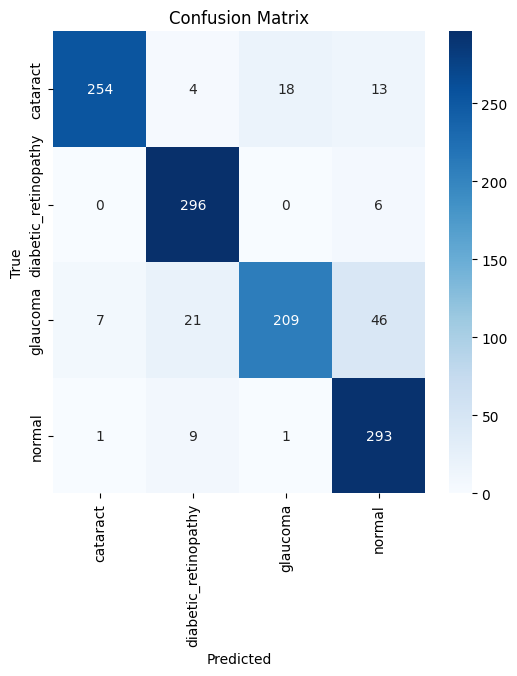

In [119]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES,
           cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [120]:
efficient_b0_model.save("eye_efficient_b0_model.h5")

In [121]:
img_path = "/kaggle/input/eye-test/eye.jpg"
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)/255.0
img_array = tf.expand_dims(img_array, axis=0)  # batch dimension

pred = efficient_b0_model.predict(img_array)
print(f"Predicted class: {CLASS_NAMES[np.argmax(pred)]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted class: cataract


# Prepare & load data for EfficientNetB3

In [86]:
IMG_SIZE = (300, 300) 
BATCH_SIZE = 32

train_ds_300=tf.keras.utils.image_dataset_from_directory(
    '/kaggle/working/dataset_split/train',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    # shuffle=True
)


val_ds_300=tf.keras.utils.image_dataset_from_directory(
    '/kaggle/working/dataset_split/val',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds_300=tf.keras.utils.image_dataset_from_directory(
    '/kaggle/working/dataset_split/test',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 3846 files belonging to 4 classes.
Found 1165 files belonging to 4 classes.
Found 1178 files belonging to 4 classes.


In [87]:
data_aug_300=tf.keras.Sequential([
    layers.RandomFlip('horizontal'),    # flip left-right
    layers.RandomRotation(0.1),         # rotate ±10%
    layers.RandomZoom(0.1),             # zoom in/out
    layers.RandomContrast(0.1),         # adjust brightness
])

In [88]:
train_ds_300 = train_ds_300.shuffle(1000)

AUTOTUNE = tf.data.AUTOTUNE

train_ds_300 = train_ds_300.prefetch(buffer_size=AUTOTUNE)
val_ds_300 = val_ds_300.prefetch(buffer_size=AUTOTUNE)
test_ds_300 = test_ds_300.prefetch(buffer_size=AUTOTUNE)

# EfficientNetB3

In [95]:
inputs = Input(shape=(300,300,3))   
x = data_aug_300(inputs)                 
x = preprocess_input(x)               

base_model3 = EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(300,300,3)        
)

x = base_model3(x)                           
x = GlobalAveragePooling2D()(x)
outputs = Dense(4, activation="softmax")(x)

efficient_b3_model = Model(inputs, outputs)

In [96]:
efficient_b3_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [97]:
efficient_b3_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 10, 10, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │         6,148 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,789,683 (41.16 MB)

 Trainable params: 10,702,380 (40.83 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [98]:
#callback
early_stopping= EarlyStopping(
    patience=10, 
    restore_best_weights=True
) 


reduce_lr =ReduceLROnPlateau(
    monitor='val_acc',
    patience=2,
    verbose=1,
    factor=0.5,
    min_lr=1e-6
)

In [99]:
history_b3=efficient_b3_model.fit(
    train_ds_300,
    validation_data=val_ds_300,
    epochs=100,
    callbacks=[early_stopping,reduce_lr]

)

Epoch 1/100


E0000 00:00:1768421338.634661    3044 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_10_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


121/121 ━━━━━━━━━━━━━━━━━━━━ 170s 891ms/step - accuracy: 0.7547 - loss: 0.6350 - val_accuracy: 0.8730 - val_loss: 0.4424 - learning_rate: 0.0010
Epoch 2/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 110s 849ms/step - accuracy: 0.8813 - loss: 0.3380 - val_accuracy: 0.9185 - val_loss: 0.2601 - learning_rate: 0.0010
Epoch 3/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 109s 845ms/step - accuracy: 0.9088 - loss: 0.2506 - val_accuracy: 0.9021 - val_loss: 0.3323 - learning_rate: 0.0010
Epoch 4/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 109s 843ms/step - accuracy: 0.9140 - loss: 0.2491 - val_accuracy: 0.8764 - val_loss: 0.4038 - learning_rate: 0.0010
Epoch 5/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 109s 847ms/step - accuracy: 0.9162 - loss: 0.2296 - val_accuracy: 0.9150 - val_loss: 0.2243 - learning_rate: 0.0010
Epoch 6/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 111s 859ms/step - accuracy: 0.9315 - loss: 0.1819 - val_accuracy: 0.9245 - val_loss: 0.2125 - learning_rate: 0.0010
Epoch 7/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 110s 856ms/step - accuracy: 0

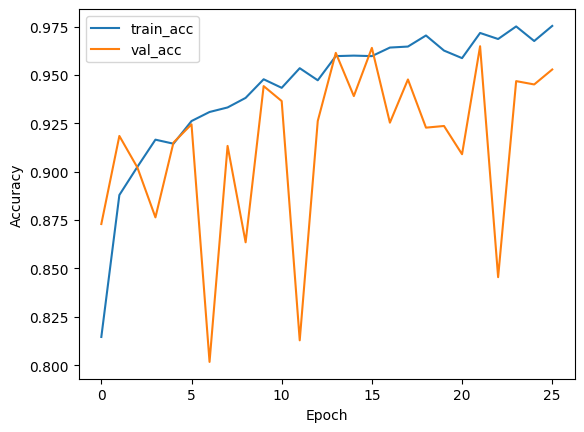

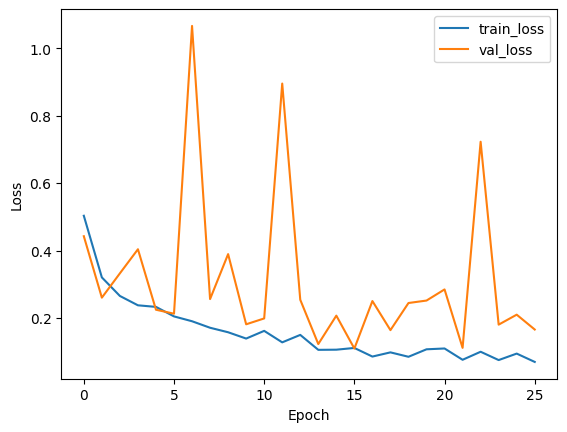

In [100]:
plt.plot(history_b3.history['accuracy'], label='train_acc')
plt.plot(history_b3.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history_b3.history['loss'], label='train_loss')
plt.plot(history_b3.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [101]:
test_loss, test_acc= efficient_b3_model.evaluate(test_ds_300)
print(f"tess_loss: {test_loss}")
print(f"test_acc: {test_acc}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - accuracy: 0.9606 - loss: 0.1145
tess_loss: 0.08885006606578827
test_acc: 0.9702886343002319


In [102]:
y_true=np.concatenate([y for x, y in test_ds_300],axis=0)
y_pred=np.concatenate([np.argmax(efficient_b3_model.predict(x),axis=1)for x, y in test_ds_300], axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [104]:
report=classification_report(y_true, y_pred, target_names=CLASS_NAMES)
print(report)

                      precision    recall  f1-score   support

            cataract       0.98      0.97      0.98       289
diabetic_retinopathy       1.00      1.00      1.00       302
            glaucoma       0.98      0.94      0.96       283
              normal       0.93      0.97      0.95       304

            accuracy                           0.97      1178
           macro avg       0.97      0.97      0.97      1178
        weighted avg       0.97      0.97      0.97      1178



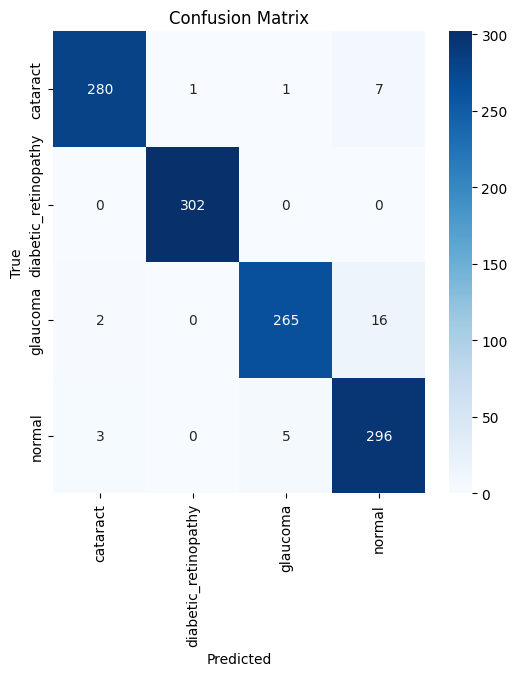

In [105]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES,
            cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [106]:
efficient_b3_model.save("eye_efficient_b3_model.h5")

In [107]:
img_path = "/kaggle/input/eye-test/eye.jpg"
img = image.load_img(img_path, target_size=(300,300))
img_array = image.img_to_array(img)/255.0
img_array = tf.expand_dims(img_array, axis=0)  # batch dimension

pred = efficient_b3_model.predict(img_array)
print(f"Predicted class: {CLASS_NAMES[np.argmax(pred)]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
Predicted class: cataract


# Fine-Tuning EfficientNetB0


In [122]:
base.trainable

False

In [123]:
base_model3.trainable

True

In [124]:
num_layers=len(base.layers)
for layer in base.layers[:int(.8*num_layers)]:
    layer.trainable=False
for layer in base.layers[int(.8*num_layers):]:
    layers.trainable=True


In [126]:
efficient_b0_model.compile(
    optimizer=Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [127]:
#callback
early_stopping= EarlyStopping(
    patience=10, 
    restore_best_weights=True
) 


reduce_lr =ReduceLROnPlateau(
    monitor='val_acc',
    patience=2,
    verbose=1,
    factor=0.5,
    min_lr=1e-7
)

checkpoint = ModelCheckpoint(
    'finetuned_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [129]:
# Continue training
history_finetune = efficient_b0_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/100


E0000 00:00:1768426241.011632    3044 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9373 - loss: 0.1686
Epoch 1: val_loss improved from inf to 0.31750, saving model to finetuned_model.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 97ms/step - accuracy: 0.9373 - loss: 0.1685 - val_accuracy: 0.8893 - val_loss: 0.3175 - learning_rate: 1.0000e-05
Epoch 2/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9381 - loss: 0.1814
Epoch 2: val_loss did not improve from 0.31750
121/121 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.9380 - loss: 0.1813 - val_accuracy: 0.8893 - val_loss: 0.3219 - learning_rate: 1.0000e-05
Epoch 3/100
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9410 - loss: 0.1566
Epoch 3: val_loss did not improve from 0.31750
121/121 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.9410 - loss: 0.1567 - val_accuracy: 0.8893 - val_loss: 0.3257 - learning_rate: 1.0000e-05
Epoch 4/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9283 - loss: 0.1733
Epoch 4: val_loss did not improve from 0.31750
121/121 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.9283 - loss: 0.1733 - val_accuracy: 0.8893 - val_loss: 0.3266 - learning_rate: 1.0000e-05
Epoch 5

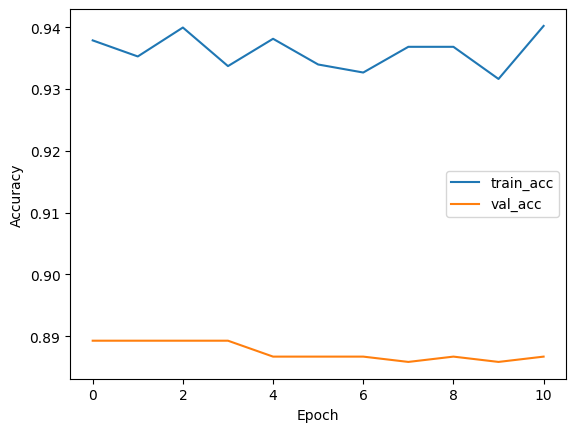

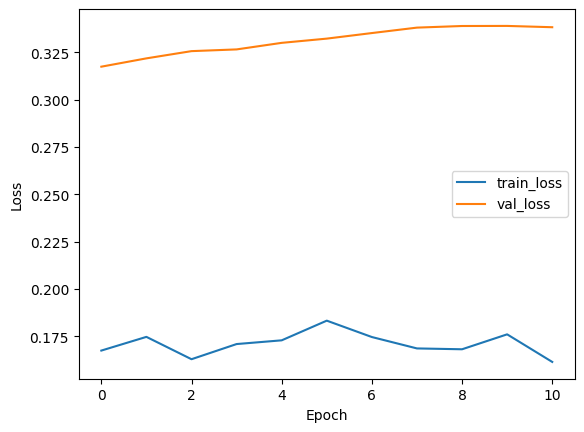

In [130]:
plt.plot(history_finetune.history['accuracy'], label='train_acc')
plt.plot(history_finetune.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history_finetune.history['loss'], label='train_loss')
plt.plot(history_finetune.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [131]:
test_loss, test_acc= efficient_b0_model.evaluate(test_ds)
print(f"tess_loss: {test_loss}")
print(f"test_acc: {test_acc}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.8893 - loss: 0.3274
tess_loss: 0.31798169016838074
test_acc: 0.8930390477180481


In [132]:
y_true=np.concatenate([y for x, y in test_ds],axis=0)
y_pred=np.concatenate([np.argmax(efficient_b0_model.predict(x),axis=1)for x, y in test_ds], axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━

In [133]:
report=classification_report(y_true, y_pred, target_names=CLASS_NAMES)
print(report)

                      precision    recall  f1-score   support

            cataract       0.97      0.89      0.93       289
diabetic_retinopathy       0.89      0.98      0.93       302
            glaucoma       0.93      0.72      0.82       283
              normal       0.82      0.96      0.88       304

            accuracy                           0.89      1178
           macro avg       0.90      0.89      0.89      1178
        weighted avg       0.90      0.89      0.89      1178



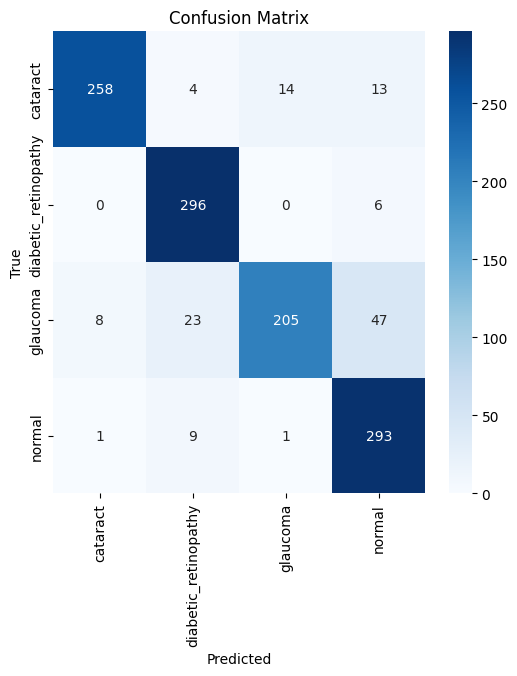

In [134]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES,
            cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [135]:
efficient_b0_model.save("finetuned_model.h5")

In [136]:
img_path = "/kaggle/input/eye-test/eye.jpg"
img = image.load_img(img_path, target_size=(300,300))
img_array = image.img_to_array(img)/255.0
img_array = tf.expand_dims(img_array, axis=0)  # batch dimension

pred = efficient_b3_model.predict(img_array)
print(f"Predicted class: {CLASS_NAMES[np.argmax(pred)]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted class: cataract
